# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import pimmslearn
import pimmslearn.analyzers
import pimmslearn.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
pimmslearn.plotting.make_large_descriptors(fontsize)


logger = pimmslearn.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "CF"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = pimmslearn.nb.get_params(args, globals=globals())
args = pimmslearn.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = pimmslearn.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'CF',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = pimmslearn.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

pimmslearn.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


pimmslearn.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


pimmslearn.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups
Sample_201  P09972           17.889
Sample_108  P02743           18.097
Sample_168  Q5T848           17.308
Sample_112  P84157-2         12.332
Sample_098  Q7Z3B1           20.596
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = pimmslearn.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[pimmslearn.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = pimmslearn.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by CF: runs/alzheimer_study/preds/pred_real_na_CF.csv


Sample ID   protein groups          
Sample_035  O14793                     14.687
Sample_160  A0A0C4DGY8;D6RA00;Q9UHY7   13.748
Sample_018  Q99538                     15.410
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 13.171
            A0A075B6Q5                 13.631
            A0A075B6R2                 13.195
            A0A075B6S5                 11.621
            A0A087WSY4                 11.908
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   11.963
            Q9UI40;Q9UI40-2            12.467
            Q9UIW2                     13.459
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   13.365
            Q9UP79                     12.965
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,14.684,15.050,16.842,19.863,15.860,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,16.772,19.067,...,15.528,15.576,14.464,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,15.798,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,14.388,17.705,17.039,15.929,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,15.633,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,15.034,15.345,17.084,18.708,14.249,19.433,12.030,10.606
Sample_207,15.739,16.877,15.469,16.898,13.969,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6K4,...,O14793,O95479;R4GMU1,P01282;P01282-2,P10619;P10619-2;X6R5C5;X6R8A1,P21810,Q14956;Q14956-2,Q6ZMP0;Q6ZMP0-2,Q9HBW1,Q9NY15,P17050
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,16.148,...,14.187,13.117,11.612,13.733,11.166,13.256,13.352,12.925,12.232,12.943
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,12.174,19.067,16.127,...,13.401,13.189,12.948,12.407,14.095,11.986,11.879,14.102,13.145,12.937
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,15.387,...,12.936,13.210,13.672,12.329,12.125,11.840,13.849,11.627,12.764,13.491
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,16.565,...,13.069,13.842,11.873,13.302,12.108,13.628,14.075,12.636,13.070,12.672
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,16.418,...,14.075,13.553,12.985,13.003,12.534,12.349,13.254,12.696,13.358,13.690
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,12.760,16.413,19.102,15.350,...,14.269,14.064,16.826,18.182,15.225,15.044,14.192,16.605,14.995,14.257
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,16.582,...,14.273,17.700,16.802,20.202,15.280,15.086,13.978,18.086,15.557,14.171
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,15.768,...,14.473,16.882,16.917,20.105,15.690,15.135,13.138,17.066,15.706,15.690


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 325.24it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  7.92it/s]

100%|██████████| 2/2 [00:00<00:00,  7.84it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  8.26it/s]

100%|██████████| 3/3 [00:00<00:00,  5.67it/s]

100%|██████████| 3/3 [00:00<00:00,  6.02it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  7.32it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  4.87it/s]

100%|██████████| 4/4 [00:00<00:00,  4.19it/s]

100%|██████████| 4/4 [00:00<00:00,  4.59it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  7.69it/s]

 60%|██████    | 3/5 [00:00<00:00,  5.49it/s]

 80%|████████  | 4/5 [00:00<00:00,  4.69it/s]

100%|██████████| 5/5 [00:01<00:00,  4.27it/s]

100%|██████████| 5/5 [00:01<00:00,  4.74it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  7.92it/s]

 50%|█████     | 3/6 [00:00<00:00,  5.57it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  4.76it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  4.23it/s]

100%|██████████| 6/6 [00:01<00:00,  3.98it/s]

100%|██████████| 6/6 [00:01<00:00,  4.49it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  6.95it/s]

 43%|████▎     | 3/7 [00:00<00:00,  5.18it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  4.64it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  4.13it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  3.89it/s]

100%|██████████| 7/7 [00:01<00:00,  3.83it/s]

100%|██████████| 7/7 [00:01<00:00,  4.24it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00,  6.24it/s]

 38%|███▊      | 3/8 [00:00<00:01,  4.92it/s]

 50%|█████     | 4/8 [00:00<00:00,  4.04it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  4.11it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  4.10it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  4.04it/s]

100%|██████████| 8/8 [00:01<00:00,  3.87it/s]

100%|██████████| 8/8 [00:01<00:00,  4.15it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:00,  7.62it/s]

 33%|███▎      | 3/9 [00:00<00:01,  4.77it/s]

 44%|████▍     | 4/9 [00:00<00:01,  4.33it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  3.98it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  3.79it/s]

 78%|███████▊  | 7/9 [00:01<00:00,  3.75it/s]

 89%|████████▉ | 8/9 [00:01<00:00,  3.81it/s]

100%|██████████| 9/9 [00:02<00:00,  3.76it/s]

100%|██████████| 9/9 [00:02<00:00,  4.04it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  7.49it/s]

 30%|███       | 3/10 [00:00<00:01,  5.02it/s]

 40%|████      | 4/10 [00:00<00:01,  4.57it/s]

 50%|█████     | 5/10 [00:01<00:01,  4.18it/s]

 60%|██████    | 6/10 [00:01<00:01,  3.98it/s]

 70%|███████   | 7/10 [00:01<00:00,  3.92it/s]

 80%|████████  | 8/10 [00:01<00:00,  3.75it/s]

 90%|█████████ | 9/10 [00:02<00:00,  3.70it/s]

100%|██████████| 10/10 [00:02<00:00,  3.60it/s]

100%|██████████| 10/10 [00:02<00:00,  4.01it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  7.39it/s]

 27%|██▋       | 3/11 [00:00<00:01,  5.27it/s]

 36%|███▋      | 4/11 [00:00<00:01,  4.44it/s]

 45%|████▌     | 5/11 [00:01<00:01,  4.17it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  4.47it/s]

 64%|██████▎   | 7/11 [00:01<00:00,  4.37it/s]

 73%|███████▎  | 8/11 [00:01<00:00,  4.31it/s]

 82%|████████▏ | 9/11 [00:02<00:00,  3.98it/s]

 91%|█████████ | 10/11 [00:02<00:00,  4.03it/s]

100%|██████████| 11/11 [00:02<00:00,  4.01it/s]

100%|██████████| 11/11 [00:02<00:00,  4.32it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  6.13it/s]

 25%|██▌       | 3/12 [00:00<00:02,  4.42it/s]

 33%|███▎      | 4/12 [00:00<00:01,  4.26it/s]

 42%|████▏     | 5/12 [00:01<00:01,  3.90it/s]

 50%|█████     | 6/12 [00:01<00:01,  4.25it/s]

 58%|█████▊    | 7/12 [00:01<00:01,  4.01it/s]

 67%|██████▋   | 8/12 [00:01<00:01,  3.93it/s]

 75%|███████▌  | 9/12 [00:02<00:00,  3.96it/s]

 83%|████████▎ | 10/12 [00:02<00:00,  3.96it/s]

 92%|█████████▏| 11/12 [00:02<00:00,  3.78it/s]

100%|██████████| 12/12 [00:03<00:00,  3.68it/s]

100%|██████████| 12/12 [00:03<00:00,  3.99it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:02,  5.08it/s]

 23%|██▎       | 3/13 [00:00<00:02,  3.75it/s]

 31%|███       | 4/13 [00:01<00:02,  3.32it/s]

 38%|███▊      | 5/13 [00:01<00:02,  3.14it/s]

 46%|████▌     | 6/13 [00:01<00:02,  2.98it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.85it/s]

 62%|██████▏   | 8/13 [00:02<00:01,  2.70it/s]

 69%|██████▉   | 9/13 [00:03<00:01,  2.68it/s]

 77%|███████▋  | 10/13 [00:03<00:01,  2.63it/s]

 85%|████████▍ | 11/13 [00:03<00:00,  2.55it/s]

 92%|█████████▏| 12/13 [00:04<00:00,  2.58it/s]

100%|██████████| 13/13 [00:04<00:00,  2.83it/s]

100%|██████████| 13/13 [00:04<00:00,  2.90it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:01,  7.44it/s]

 21%|██▏       | 3/14 [00:00<00:02,  5.17it/s]

 29%|██▊       | 4/14 [00:00<00:02,  4.70it/s]

 36%|███▌      | 5/14 [00:01<00:02,  4.23it/s]

 43%|████▎     | 6/14 [00:01<00:01,  4.12it/s]

 50%|█████     | 7/14 [00:01<00:01,  4.21it/s]

 57%|█████▋    | 8/14 [00:01<00:01,  3.96it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  3.86it/s]

 71%|███████▏  | 10/14 [00:02<00:01,  3.80it/s]

 79%|███████▊  | 11/14 [00:02<00:00,  4.00it/s]

 86%|████████▌ | 12/14 [00:02<00:00,  3.91it/s]

 93%|█████████▎| 13/14 [00:03<00:00,  3.58it/s]

100%|██████████| 14/14 [00:03<00:00,  3.44it/s]

100%|██████████| 14/14 [00:03<00:00,  3.97it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:01,  7.88it/s]

 20%|██        | 3/15 [00:00<00:02,  5.83it/s]

 27%|██▋       | 4/15 [00:00<00:02,  3.72it/s]

 33%|███▎      | 5/15 [00:01<00:02,  3.39it/s]

 40%|████      | 6/15 [00:01<00:02,  3.15it/s]

 47%|████▋     | 7/15 [00:02<00:02,  2.93it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  3.00it/s]

 60%|██████    | 9/15 [00:02<00:01,  3.17it/s]

 67%|██████▋   | 10/15 [00:02<00:01,  3.01it/s]

 73%|███████▎  | 11/15 [00:03<00:01,  2.96it/s]

 80%|████████  | 12/15 [00:03<00:00,  3.16it/s]

 87%|████████▋ | 13/15 [00:03<00:00,  3.31it/s]

 93%|█████████▎| 14/15 [00:04<00:00,  3.57it/s]

100%|██████████| 15/15 [00:04<00:00,  3.47it/s]

100%|██████████| 15/15 [00:04<00:00,  3.41it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.003 0.001      0.032 0.004          0.858 0.238       0.153   
2             0.003 0.000      0.035 0.000          0.666 0.115       0.512   
3             0.003 0.000      0.035 0.000          0.781 0.103       0.767   
4             0.003 0.000      0.035 0.005          0.801 0.094       0.774   
5             0.003 0.001      0.036 0.002          0.774 0.092       0.780   
6             0.003 0.000      0.035 0.000          0.773 0.092       0.774   
7             0.004 0.001      0.036 0.003          0.775 0.094       0.776   
8             0.003 0.000      0.036 0.000          0.810 0.096       0.791   
9             0.003 0.000      0.035 0.000          0.806 0.090       0.803   
10            0.003 0.000      0.033 0.003          0.803 0.090       0.803   
11            0.003 0.000      0.033 0.004          0.823 0.084       0.803   
12            0.003 0.000      0.034 0.006          0.830 0.083       0.803   
13            0.004 0.000      0.041 0.014          0.824 0.089       0.815   
14            0.005 0.004      0.044 0.014          0.818 0.084       0.815   
15            0.004 0.003      0.042 0.013          0.820 0.084       0.811   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.088   0.251 0.126                  0.568 0.043        0.851   
2          0.124   0.568 0.098                  0.659 0.062        0.726   
3          0.105   0.768 0.078                  0.802 0.065        0.882   
4          0.105   0.782 0.076                  0.814 0.062        0.887   
5          0.093   0.772 0.068                  0.804 0.058        0.893   
6          0.088   0.769 0.064                  0.801 0.054        0.891   
7          0.085   0.771 0.065                  0.803 0.055        0.890   
8          0.094   0.796 0.071                  0.825 0.060        0.911   
9          0.078   0.800 0.061                  0.828 0.053        0.910   
10         0.080   0.799 0.061                  0.826 0.053        0.908   
11         0.084   0.809 0.063                  0.836 0.054        0.921   
12         0.084   0.813 0.065                  0.840 0.055        0.920   
13         0.089   0.816 0.068                  0.842 0.058        0.920   
14         0.092   0.813 0.067                  0.840 0.056        0.919   
15         0.096   0.811 0.069                  0.839 0.058        0.918   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.064                  0.822 0.089        210.000 0.000  
2          0.071                  0.675 0.082        210.000 0.000  
3          0.056                  0.843 0.083        210.000 0.000  
4          0.051                  0.855 0.074        210.000 0.000  
5          0.048                  0.856 0.069        210.000 0.000  
6          0.048                  0.854 0.070        210.000 0.000  
7          0.048                  0.852 0.070        210.000 0.000  
8          0.045                  0.888 0.058        210.000 0.000  
9          0.045                  0.890 0.058        210.000 0.000  
10         0.045                  0.889 0.058        210.000 0.000  
11         0.043                  0.910 0.047        210.000 0.000  
12         0.044                  0.907 0.051        210.000 0.000  
13         0.046                  0.905 0.053        210.000 0.000  
14         0.046                  0.905 0.053        210.000 0.000  
15         0.046                  0.903 0.052 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 295.42it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  7.12it/s]

100%|██████████| 2/2 [00:00<00:00,  7.09it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  5.17it/s]

100%|██████████| 3/3 [00:00<00:00,  4.24it/s]

100%|██████████| 3/3 [00:00<00:00,  4.39it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  4.64it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  3.09it/s]

100%|██████████| 4/4 [00:01<00:00,  2.70it/s]

100%|██████████| 4/4 [00:01<00:00,  2.93it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  7.21it/s]

 60%|██████    | 3/5 [00:00<00:00,  3.58it/s]

 80%|████████  | 4/5 [00:01<00:00,  3.04it/s]

100%|██████████| 5/5 [00:01<00:00,  2.74it/s]

100%|██████████| 5/5 [00:01<00:00,  3.13it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  6.11it/s]

 50%|█████     | 3/6 [00:00<00:00,  4.56it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  4.06it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.83it/s]

100%|██████████| 6/6 [00:01<00:00,  3.12it/s]

100%|██████████| 6/6 [00:01<00:00,  3.64it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  6.57it/s]

 43%|████▎     | 3/7 [00:00<00:00,  4.40it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  3.83it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  3.83it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  3.93it/s]

100%|██████████| 7/7 [00:01<00:00,  3.46it/s]

100%|██████████| 7/7 [00:01<00:00,  3.84it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  5.71it/s]

 38%|███▊      | 3/8 [00:00<00:01,  4.48it/s]

 50%|█████     | 4/8 [00:00<00:00,  4.24it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  4.07it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  3.88it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  3.92it/s]

100%|██████████| 8/8 [00:01<00:00,  3.92it/s]

100%|██████████| 8/8 [00:01<00:00,  4.10it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:00,  7.16it/s]

 33%|███▎      | 3/9 [00:00<00:01,  5.08it/s]

 44%|████▍     | 4/9 [00:00<00:01,  4.52it/s]

 56%|█████▌    | 5/9 [00:01<00:00,  4.13it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  3.90it/s]

 78%|███████▊  | 7/9 [00:01<00:00,  4.05it/s]

 89%|████████▉ | 8/9 [00:01<00:00,  3.85it/s]

100%|██████████| 9/9 [00:02<00:00,  3.74it/s]

100%|██████████| 9/9 [00:02<00:00,  4.12it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  7.26it/s]

 30%|███       | 3/10 [00:00<00:01,  5.33it/s]

 40%|████      | 4/10 [00:00<00:01,  4.43it/s]

 50%|█████     | 5/10 [00:01<00:01,  4.08it/s]

 60%|██████    | 6/10 [00:01<00:01,  3.88it/s]

 70%|███████   | 7/10 [00:01<00:00,  3.85it/s]

 80%|████████  | 8/10 [00:01<00:00,  3.76it/s]

 90%|█████████ | 9/10 [00:02<00:00,  3.84it/s]

100%|██████████| 10/10 [00:02<00:00,  3.95it/s]

100%|██████████| 10/10 [00:02<00:00,  4.14it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  7.40it/s]

 27%|██▋       | 3/11 [00:00<00:01,  5.52it/s]

 36%|███▋      | 4/11 [00:00<00:01,  4.71it/s]

 45%|████▌     | 5/11 [00:01<00:01,  4.24it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  3.96it/s]

 64%|██████▎   | 7/11 [00:01<00:01,  3.92it/s]

 73%|███████▎  | 8/11 [00:01<00:00,  3.86it/s]

 82%|████████▏ | 9/11 [00:02<00:00,  3.83it/s]

 91%|█████████ | 10/11 [00:02<00:00,  3.80it/s]

100%|██████████| 11/11 [00:02<00:00,  3.40it/s]

100%|██████████| 11/11 [00:02<00:00,  3.96it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  6.47it/s]

 25%|██▌       | 3/12 [00:00<00:01,  4.89it/s]

 33%|███▎      | 4/12 [00:00<00:01,  4.44it/s]

 42%|████▏     | 5/12 [00:01<00:01,  4.22it/s]

 50%|█████     | 6/12 [00:01<00:01,  4.00it/s]

 58%|█████▊    | 7/12 [00:01<00:01,  3.96it/s]

 67%|██████▋   | 8/12 [00:01<00:01,  3.92it/s]

 75%|███████▌  | 9/12 [00:02<00:00,  3.81it/s]

 83%|████████▎ | 10/12 [00:02<00:00,  3.73it/s]

 92%|█████████▏| 11/12 [00:02<00:00,  3.64it/s]

100%|██████████| 12/12 [00:03<00:00,  3.19it/s]

100%|██████████| 12/12 [00:03<00:00,  3.80it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:02,  4.15it/s]

 23%|██▎       | 3/13 [00:00<00:03,  3.25it/s]

 31%|███       | 4/13 [00:01<00:02,  3.01it/s]

 38%|███▊      | 5/13 [00:01<00:02,  3.04it/s]

 46%|████▌     | 6/13 [00:01<00:02,  3.20it/s]

 54%|█████▍    | 7/13 [00:02<00:01,  3.39it/s]

 62%|██████▏   | 8/13 [00:02<00:01,  3.49it/s]

 69%|██████▉   | 9/13 [00:02<00:01,  3.64it/s]

 77%|███████▋  | 10/13 [00:02<00:00,  3.53it/s]

 85%|████████▍ | 11/13 [00:03<00:00,  3.67it/s]

 92%|█████████▏| 12/13 [00:03<00:00,  3.24it/s]

100%|██████████| 13/13 [00:04<00:00,  2.84it/s]

100%|██████████| 13/13 [00:04<00:00,  3.22it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:01,  7.62it/s]

 21%|██▏       | 3/14 [00:00<00:02,  5.04it/s]

 29%|██▊       | 4/14 [00:00<00:02,  4.41it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.33it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.04it/s]

 50%|█████     | 7/14 [00:01<00:02,  3.02it/s]

 57%|█████▋    | 8/14 [00:02<00:02,  2.83it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  2.67it/s]

 71%|███████▏  | 10/14 [00:03<00:01,  2.80it/s]

 79%|███████▊  | 11/14 [00:03<00:00,  3.03it/s]

 86%|████████▌ | 12/14 [00:03<00:00,  3.04it/s]

 93%|█████████▎| 13/14 [00:04<00:00,  2.82it/s]

100%|██████████| 14/14 [00:04<00:00,  2.66it/s]

100%|██████████| 14/14 [00:04<00:00,  3.06it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  5.30it/s]

 20%|██        | 3/15 [00:00<00:02,  4.28it/s]

 27%|██▋       | 4/15 [00:00<00:02,  4.08it/s]

 33%|███▎      | 5/15 [00:01<00:02,  3.90it/s]

 40%|████      | 6/15 [00:01<00:02,  3.83it/s]

 47%|████▋     | 7/15 [00:01<00:02,  3.99it/s]

 53%|█████▎    | 8/15 [00:01<00:01,  3.94it/s]

 60%|██████    | 9/15 [00:02<00:01,  3.83it/s]

 67%|██████▋   | 10/15 [00:02<00:01,  3.69it/s]

 73%|███████▎  | 11/15 [00:02<00:01,  3.68it/s]

 80%|████████  | 12/15 [00:03<00:00,  3.68it/s]

 87%|████████▋ | 13/15 [00:03<00:00,  2.81it/s]

 93%|█████████▎| 14/15 [00:04<00:00,  2.76it/s]

100%|██████████| 15/15 [00:04<00:00,  2.68it/s]

100%|██████████| 15/15 [00:04<00:00,  3.39it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.002      0.042 0.015          0.087 0.248       0.009   
2             0.003 0.000      0.036 0.003          0.692 0.161       0.284   
3             0.004 0.002      0.039 0.013          0.661 0.102       0.604   
4             0.004 0.003      0.048 0.017          0.678 0.106       0.608   
5             0.005 0.004      0.045 0.015          0.736 0.107       0.675   
6             0.004 0.003      0.059 0.024          0.769 0.098       0.705   
7             0.006 0.006      0.062 0.023          0.784 0.094       0.772   
8             0.005 0.005      0.060 0.022          0.788 0.093       0.775   
9             0.006 0.006      0.068 0.024          0.782 0.089       0.765   
10            0.006 0.005      0.070 0.027          0.822 0.085       0.815   
11            0.006 0.006      0.069 0.026          0.819 0.088       0.810   
12            0.006 0.005      0.064 0.029          0.822 0.091       0.843   
13            0.007 0.006      0.063 0.025          0.834 0.089       0.830   
14            0.008 0.011      0.054 0.022          0.820 0.095       0.815   
15            0.005 0.003      0.046 0.020          0.816 0.099       0.810   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.028   0.017 0.048                  0.501 0.012        0.866   
2          0.101   0.389 0.110                  0.590 0.049        0.688   
3          0.110   0.627 0.091                  0.687 0.071        0.783   
4          0.104   0.637 0.091                  0.697 0.071        0.777   
5          0.111   0.697 0.086                  0.745 0.069        0.806   
6          0.093   0.731 0.072                  0.772 0.058        0.847   
7          0.110   0.772 0.078                  0.806 0.066        0.906   
8          0.110   0.775 0.074                  0.809 0.062        0.904   
9          0.110   0.768 0.075                  0.802 0.063        0.902   
10         0.099   0.814 0.072                  0.842 0.062        0.917   
11         0.105   0.810 0.075                  0.838 0.064        0.917   
12         0.100   0.827 0.070                  0.852 0.060        0.921   
13         0.100   0.826 0.068                  0.852 0.057        0.924   
14         0.096   0.812 0.068                  0.839 0.058        0.922   
15         0.094   0.808 0.069                  0.835 0.059        0.921   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.060                  0.834 0.088        210.000 0.000  
2          0.096                  0.645 0.099        210.000 0.000  
3          0.066                  0.733 0.096        210.000 0.000  
4          0.067                  0.728 0.095        210.000 0.000  
5          0.061                  0.778 0.082        210.000 0.000  
6          0.056                  0.826 0.069        210.000 0.000  
7          0.048                  0.883 0.059        210.000 0.000  
8          0.049                  0.880 0.060        210.000 0.000  
9          0.050                  0.881 0.057        210.000 0.000  
10         0.047                  0.900 0.052        210.000 0.000  
11         0.047                  0.900 0.053        210.000 0.000  
12         0.045                  0.908 0.049        210.000 0.000  
13         0.044                  0.911 0.048        210.000 0.000  
14         0.044                  0.908 0.049        210.000 0.000  
15         0.044                  0.906 0.049 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 1076.01it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 34.27it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 24.38it/s]

100%|██████████| 3/3 [00:00<00:00, 24.18it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 75%|███████▌  | 3/4 [00:00<00:00, 18.28it/s]

100%|██████████| 4/4 [00:00<00:00, 15.12it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 60%|██████    | 3/5 [00:00<00:00, 26.04it/s]

100%|██████████| 5/5 [00:00<00:00, 19.93it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00, 18.87it/s]

 67%|██████▋   | 4/6 [00:00<00:00, 12.92it/s]

100%|██████████| 6/6 [00:00<00:00, 11.02it/s]

100%|██████████| 6/6 [00:00<00:00, 11.50it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 43%|████▎     | 3/7 [00:00<00:00, 20.14it/s]

 86%|████████▌ | 6/7 [00:00<00:00, 17.61it/s]

100%|██████████| 7/7 [00:00<00:00, 17.54it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 38%|███▊      | 3/8 [00:00<00:00, 26.97it/s]

 75%|███████▌  | 6/8 [00:00<00:00, 15.52it/s]

100%|██████████| 8/8 [00:00<00:00, 14.54it/s]

100%|██████████| 8/8 [00:00<00:00, 15.34it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 33%|███▎      | 3/9 [00:00<00:00, 18.84it/s]

 56%|█████▌    | 5/9 [00:00<00:00, 15.93it/s]

 78%|███████▊  | 7/9 [00:00<00:00, 15.17it/s]

100%|██████████| 9/9 [00:00<00:00, 12.05it/s]

100%|██████████| 9/9 [00:00<00:00, 13.26it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 30%|███       | 3/10 [00:00<00:00, 15.95it/s]

 50%|█████     | 5/10 [00:00<00:00, 14.20it/s]

 70%|███████   | 7/10 [00:00<00:00, 13.21it/s]

 90%|█████████ | 9/10 [00:00<00:00, 13.72it/s]

100%|██████████| 10/10 [00:00<00:00, 12.84it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 27%|██▋       | 3/11 [00:00<00:00, 22.17it/s]

 55%|█████▍    | 6/11 [00:00<00:00, 17.11it/s]

 73%|███████▎  | 8/11 [00:00<00:00, 17.10it/s]

 91%|█████████ | 10/11 [00:00<00:00, 15.38it/s]

100%|██████████| 11/11 [00:00<00:00, 15.95it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 25%|██▌       | 3/12 [00:00<00:00, 25.34it/s]

 50%|█████     | 6/12 [00:00<00:00, 16.11it/s]

 67%|██████▋   | 8/12 [00:00<00:00, 13.16it/s]

 83%|████████▎ | 10/12 [00:00<00:00, 12.90it/s]

100%|██████████| 12/12 [00:00<00:00, 13.45it/s]

100%|██████████| 12/12 [00:00<00:00, 14.07it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 23%|██▎       | 3/13 [00:00<00:00, 21.85it/s]

 46%|████▌     | 6/13 [00:00<00:00, 15.46it/s]

 62%|██████▏   | 8/13 [00:00<00:00, 15.67it/s]

 77%|███████▋  | 10/13 [00:00<00:00, 14.24it/s]

 92%|█████████▏| 12/13 [00:00<00:00, 12.89it/s]

100%|██████████| 13/13 [00:00<00:00, 14.24it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 21%|██▏       | 3/14 [00:00<00:00, 21.73it/s]

 43%|████▎     | 6/14 [00:00<00:00, 13.49it/s]

 57%|█████▋    | 8/14 [00:00<00:00, 13.22it/s]

 71%|███████▏  | 10/14 [00:00<00:00, 13.35it/s]

 86%|████████▌ | 12/14 [00:00<00:00, 13.30it/s]

100%|██████████| 14/14 [00:01<00:00, 12.81it/s]

100%|██████████| 14/14 [00:01<00:00, 13.41it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 20%|██        | 3/15 [00:00<00:00, 22.32it/s]

 40%|████      | 6/15 [00:00<00:00, 17.28it/s]

 53%|█████▎    | 8/15 [00:00<00:00, 16.20it/s]

 67%|██████▋   | 10/15 [00:00<00:00, 15.81it/s]

 80%|████████  | 12/15 [00:00<00:00, 15.04it/s]

 93%|█████████▎| 14/15 [00:00<00:00, 14.58it/s]

100%|██████████| 15/15 [00:00<00:00, 15.35it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.003 0.000      0.033 0.008          0.000 0.000       0.000   
2             0.005 0.004      0.047 0.016          0.648 0.093       0.543   
3             0.004 0.002      0.045 0.018          0.631 0.094       0.524   
4             0.003 0.001      0.043 0.016          0.684 0.100       0.569   
5             0.004 0.004      0.038 0.017          0.713 0.090       0.624   
6             0.006 0.005      0.069 0.025          0.718 0.083       0.638   
7             0.004 0.002      0.052 0.026          0.716 0.095       0.633   
8             0.006 0.005      0.055 0.021          0.700 0.087       0.633   
9             0.004 0.003      0.044 0.015          0.694 0.081       0.632   
10            0.005 0.005      0.055 0.025          0.705 0.094       0.638   
11            0.008 0.008      0.066 0.026          0.703 0.111       0.632   
12            0.005 0.005      0.052 0.020          0.709 0.113       0.642   
13            0.004 0.003      0.048 0.016          0.714 0.087       0.667   
14            0.005 0.005      0.052 0.021          0.717 0.087       0.661   
15            0.010 0.009      0.074 0.036          0.710 0.088       0.675   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.500 0.000        0.732   
2          0.120   0.584 0.091                  0.663 0.063        0.715   
3          0.115   0.566 0.089                  0.649 0.062        0.708   
4          0.096   0.616 0.080                  0.687 0.061        0.744   
5          0.107   0.661 0.084                  0.719 0.065        0.791   
6          0.111   0.670 0.083                  0.726 0.063        0.814   
7          0.114   0.667 0.089                  0.724 0.069        0.813   
8          0.108   0.660 0.082                  0.716 0.065        0.811   
9          0.107   0.657 0.081                  0.714 0.063        0.811   
10         0.113   0.662 0.081                  0.719 0.061        0.809   
11         0.108   0.660 0.091                  0.716 0.073        0.815   
12         0.111   0.670 0.099                  0.723 0.080        0.821   
13         0.112   0.685 0.085                  0.735 0.069        0.832   
14         0.107   0.683 0.081                  0.734 0.066        0.829   
15         0.108   0.688 0.084                  0.736 0.067        0.827   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.070                  0.679 0.088        210.000 0.000  
2          0.085                  0.679 0.090        210.000 0.000  
3          0.080                  0.671 0.084        210.000 0.000  
4          0.078                  0.717 0.079        210.000 0.000  
5          0.073                  0.780 0.072        210.000 0.000  
6          0.070                  0.794 0.073        210.000 0.000  
7          0.073                  0.791 0.076        210.000 0.000  
8          0.075                  0.790 0.076        210.000 0.000  
9          0.073                  0.790 0.077        210.000 0.000  
10         0.076                  0.788 0.085        210.000 0.000  
11         0.075                  0.799 0.085        210.000 0.000  
12         0.072                  0.807 0.080        210.000 0.000  
13         0.071                  0.812 0.080        210.000 0.000  
14         0.072                  0.804 0.085        210.000 0.000  
15         0.075                  0.800 0.087 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,14,14,15
score_time,14,10,15
test_precision,1,13,6
test_recall,14,12,15
test_f1,13,12,15
test_balanced_accuracy,13,12,15
test_roc_auc,11,13,13
test_average_precision,11,13,13
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_ald_full, fname)

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:02,  4.92it/s]

 23%|██▎       | 3/13 [00:00<00:02,  3.88it/s]

 31%|███       | 4/13 [00:01<00:02,  3.00it/s]

 38%|███▊      | 5/13 [00:01<00:02,  3.09it/s]

 46%|████▌     | 6/13 [00:01<00:02,  2.64it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.48it/s]

 62%|██████▏   | 8/13 [00:02<00:02,  2.44it/s]

 69%|██████▉   | 9/13 [00:03<00:01,  2.34it/s]

 77%|███████▋  | 10/13 [00:03<00:01,  2.31it/s]

 85%|████████▍ | 11/13 [00:04<00:00,  2.34it/s]

 92%|█████████▏| 12/13 [00:04<00:00,  2.41it/s]

100%|██████████| 13/13 [00:04<00:00,  2.53it/s]

100%|██████████| 13/13 [00:04<00:00,  2.63it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:00, 16.62it/s]

 31%|███       | 4/13 [00:00<00:00, 12.13it/s]

 46%|████▌     | 6/13 [00:00<00:00, 12.11it/s]

 62%|██████▏   | 8/13 [00:00<00:00, 11.46it/s]

 77%|███████▋  | 10/13 [00:00<00:00, 10.75it/s]

 92%|█████████▏| 12/13 [00:01<00:00, 10.88it/s]

100%|██████████| 13/13 [00:01<00:00, 11.38it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  8.18it/s]

 27%|██▋       | 3/11 [00:00<00:01,  5.52it/s]

 36%|███▋      | 4/11 [00:00<00:01,  4.43it/s]

 45%|████▌     | 5/11 [00:01<00:01,  4.03it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  3.89it/s]

 64%|██████▎   | 7/11 [00:01<00:01,  3.66it/s]

 73%|███████▎  | 8/11 [00:02<00:00,  3.39it/s]

 82%|████████▏ | 9/11 [00:02<00:00,  2.97it/s]

 91%|█████████ | 10/11 [00:02<00:00,  2.70it/s]

100%|██████████| 11/11 [00:03<00:00,  2.59it/s]

100%|██████████| 11/11 [00:03<00:00,  3.31it/s]

### ROC-AUC on test split

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/auc_roc_curve.pdf


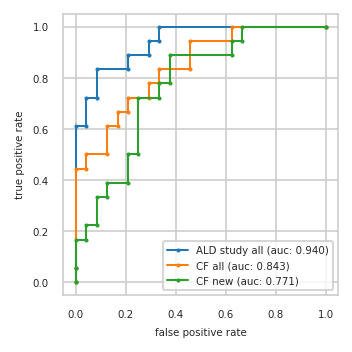

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       CF all       CF new      
             fpr   tpr    fpr   tpr    fpr   tpr
0          0.000 0.000  0.000 0.000  0.000 0.000
1          0.000 0.056  0.000 0.056  0.000 0.056
2          0.000 0.611  0.000 0.444  0.000 0.167
3          0.042 0.611  0.042 0.444  0.042 0.167
4          0.042 0.722  0.042 0.500  0.042 0.222
5          0.083 0.722  0.125 0.500  0.083 0.222
6          0.083 0.833  0.125 0.611  0.083 0.333
7          0.208 0.833  0.167 0.611  0.125 0.333
8          0.208 0.889  0.167 0.667  0.125 0.389
9          0.292 0.889  0.208 0.667  0.208 0.389
10         0.292 0.944  0.208 0.722  0.208 0.500
11         0.333 0.944  0.292 0.722  0.250 0.500
12         0.333 1.000  0.292 0.778  0.250 0.722
13         1.000 1.000  0.333 0.778  0.333 0.722
14           NaN   NaN  0.333 0.833  0.333 0.778
15           NaN   NaN  0.458 0.833  0.375 0.778
16           NaN   NaN  0.458 0.944  0.375 0.889
17           NaN   NaN  0.625 0.944  0.625 0.889
18           NaN   NaN  0.625 1.000  0.625 0.944
19           NaN   NaN  1.000 1.000  0.667 0.944
20           NaN   NaN    NaN   NaN  0.667 1.000
21           NaN   NaN    NaN   NaN  1.000 1.000

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,CF all,CF new
rank,,,
0,P10636-2;P10636-6,P10636-2;P10636-6,Q14894
1,Q9NZ53,Q92542;Q92542-2,P51688
2,Q92743,P21333;P21333-2;Q5HY54,E5RK69;E7EMC6;P08133;P08133-2
3,P04075,P51674;P51674-2;P51674-3,B1AJQ6;Q86Y82
4,Q16674;W4VSR3,P04075,A0A075B7B8
5,P61981,Q9Y2T3;Q9Y2T3-3,P31321
6,P14174,P61981,F8WBF9;Q5TH30;Q9UGV2;Q9UGV2-2;Q9UGV2-3
7,P08294,P14174,Q9H741
8,Q9Y2T3;Q9Y2T3-3,Q14894,Q96GD0


### Precision-Recall plot on test data

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/prec_recall_curve.pdf


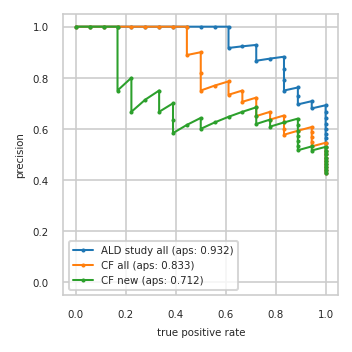

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all          CF all          CF new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.450 1.000
3          0.462 1.000     0.462 1.000     0.462 1.000
4          0.474 1.000     0.474 1.000     0.474 1.000
5          0.486 1.000     0.486 1.000     0.486 1.000
6          0.500 1.000     0.500 1.000     0.500 1.000
7          0.514 1.000     0.514 1.000     0.514 1.000
8          0.529 1.000     0.529 1.000     0.529 1.000
9          0.545 1.000     0.545 1.000     0.515 0.944
10         0.562 1.000     0.531 0.944     0.531 0.944
11         0.581 1.000     0.548 0.944     0.516 0.889
12         0.600 1.000     0.567 0.944     0.533 0.889
13         0.621 1.000     0.586 0.944     0.552 0.889
14         0.643 1.000     0.607 0.944     0.571 0.889
15         0.667 1.000     0.593 0.889     0.593 0.889
16         0.692 1.000     0.577 0.833     0.615 0.889
17         0.680 0.944     0.600 0.833     0.640 0.889
18         0.708 0.944     0.625 0.833     0.625 0.833
19         0.696 0.889     0.652 0.833     0.609 0.778
20         0.727 0.889     0.636 0.778     0.636 0.778
21         0.762 0.889     0.667 0.778     0.619 0.722
22         0.750 0.833     0.650 0.722     0.650 0.722
23         0.789 0.833     0.684 0.722     0.684 0.722
24         0.833 0.833     0.722 0.722     0.667 0.667
25         0.882 0.833     0.706 0.667     0.647 0.611
26         0.875 0.778     0.750 0.667     0.625 0.556
27         0.867 0.722     0.733 0.611     0.600 0.500
28         0.929 0.722     0.786 0.611     0.643 0.500
29         0.923 0.667     0.769 0.556     0.615 0.444
30         0.917 0.611     0.750 0.500     0.583 0.389
31         1.000 0.611     0.818 0.500     0.636 0.389
32         1.000 0.556     0.900 0.500     0.700 0.389
33         1.000 0.500     0.889 0.444     0.667 0.333
34         1.000 0.444     1.000 0.444     0.750 0.333
35         1.000 0.389     1.000 0.389     0.714 0.278
36         1.000 0.333     1.000 0.333     0.667 0.222
37         1.000 0.278     1.000 0.278     0.800 0.222
38         1.000 0.222     1.000 0.222     0.750 0.167
39         1.000 0.167     1.000 0.167     1.000 0.167
40         1.000 0.111     1.000 0.111     1.000 0.111
41         1.000 0.056     1.000 0.056     1.000 0.056
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/prec_recall_curve_train.pdf


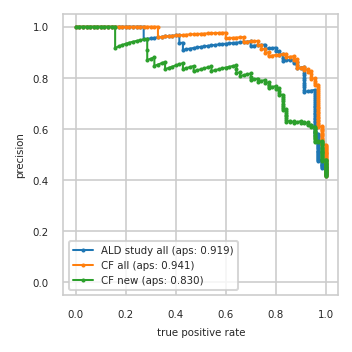

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/auc_roc_curve_train.pdf


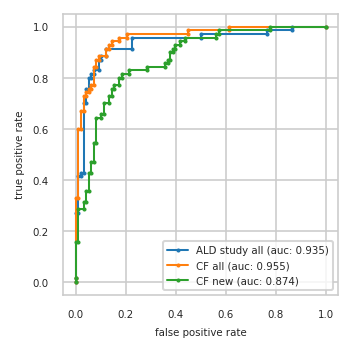

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_CF all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/results_CF all.pkl'),
 'results_CF new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/results_CF new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/auc_roc_curve_train.pdf')}